In [1]:
import pandas as pd
import polars as pl
import numpy as np
import pickle, warnings, datetime, pytz
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler
warnings.filterwarnings('ignore')

In [2]:
with open(r'../../data/processed/gdelt_intermediate_cleaned.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
# Drop duplicate rows
df.drop_duplicates(subset=['GKGRECORDID'], inplace=True)

df.index = df['GKGRECORDID']
df.drop(columns=['GKGRECORDID'], inplace=True)
df.drop(columns=['Positive Score','Negative Score','Activity Reference Density','Self/Group Reference Density'], inplace=True)
df.drop(columns=[i for i in df.columns if 'SCOREDVALUE' in i], inplace=True)
df.drop(columns=[i for i in df.columns if 'WORDCOUNT' in i], inplace=True)

In [4]:
# Convert from UTC to EST, accounting for daylight saving time
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)
df['datetime'] = df['datetime'].dt.tz_convert('America/New_York')
# Remove the timezone information 
df['datetime'] = df['datetime'].dt.tz_localize(None)
df['date'] = df['datetime'].dt.date

In [12]:
titles = df[['article_title', 'Tone']]
titles['article_title'].replace(r'_', ' ', regex=True, inplace=True)

titles['article_title'] = titles['article_title'].str.split(' ')
titles = titles.explode('article_title', ignore_index=True)
#titles.melt()
titles['count'] = 1

titles = titles.groupby('article_title').agg(
    {'Tone': 'mean',
     'count': 'sum'}
     ).sort_values(by='count', ascending=False).reset_index()

titles

,article_title,Tone,count
0,to,-1.247470,349954
1,airlines,-1.344747,223089
2,in,-1.722440,192616
3,the,-1.140586,173103
4,of,-1.799979,158067
...,...,...,...
257162,|carletonville,4.311774,1
257163,|cellular,2.550725,1
257164,|chain,6.648936,1
257165,|compound,-0.132275,1


In [18]:
# Count missing article titles
#df[df['article_title']]
df

,V2SOURCECOMMONNAME,V2DOCUMENTIDENTIFIER,V1THEMES,datetime,date,airplane,airline,airport,Alaska Airlines,American Airlines,...,Southwest Airlines,Spirit Airlines,Sun Country Airlines,United Airlines,Allegiant Air,article_title,Tone,Polarity,Word Count,disaster
GKGRECORDID,,,,,,,,,,,,,,,,,,,,,
20230221030000-453,aero-news.net,http://aero-news.net/index.cfm?do=main.textpos...,TAX_WORLDREPTILES;TAX_WORLDREPTILES_SIDEWINDER...,2023-02-20 22:00:00,2023-02-20,0,1,0,0,1,...,0,0,0,0,0,airborne 02 20 23: hobby balloon shot down per...,-1.228501,6.142506,333,False
20250117234500-581,houstonchronicle.com,http://www.houstonchronicle.com/news/politics/...,TAX_FNCACT;TAX_FNCACT_OFFICIALS;LEADER;USPEC_P...,2025-01-17 18:45:00,2025-01-17,0,1,0,0,1,...,1,0,0,1,0,trump s inauguration will be held inside what ...,0.418410,2.092050,883,False
20240527093000-676,itechpost.com,http://www.itechpost.com/articles/122528/20240...,TAX_FNCACT;TAX_FNCACT_EMPLOYEE;EPU_POLICY;EPU_...,2024-05-27 05:30:00,2024-05-27,0,1,1,0,0,...,0,0,0,1,0,boeing safety product quality concerns surge a...,-3.271028,11.214953,395,False
20250410171500-386,1025kiss.com,https://1025kiss.com/ixp/175/p/lukas-first-gam...,None,2025-04-10 13:15:00,2025-04-10,0,1,0,0,1,...,0,0,0,0,0,breaking down luka s first game back in dallas...,0.123305,6.288533,776,False
20241120131500-415,710keel.com,https://710keel.com/ixp/182/p/spirit-airlines-...,ECON_DEBT;WB_1104_MACROECONOMIC_VULNERABILITY_...,2024-11-20 08:15:00,2024-11-20,0,1,0,0,0,...,0,1,0,1,0,will spirit airlines bankruptcy ruin louisiana...,-1.453488,7.848837,307,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221216140000-613,wsiu.org,https://www.wsiu.org/2022-12-16/they-flew-to-n...,TAX_WORLDMAMMALS;TAX_WORLDMAMMALS_DOG;TAX_ETHN...,2022-12-16 09:00:00,2022-12-16,0,1,0,0,0,...,0,0,0,1,0,they flew to nashville bluebell their dog was ...,-1.756440,4.800937,783,False
20190719014500-2143,wtol.com,https://www.wtol.com/article/news/nation-world...,MANMADE_DISASTER_IMPLIED;DELAY;USPEC_UNCERTAIN...,2019-07-18 21:45:00,2019-07-18,0,1,0,0,1,...,1,0,0,0,0,nation southwest cancellations will rise due t...,-1.813472,2.849741,364,False
20190719014500-887,wwltv.com,https://www.wwltv.com/article/news/nation-worl...,MANMADE_DISASTER_IMPLIED;DELAY;USPEC_UNCERTAIN...,2019-07-18 21:45:00,2019-07-18,0,1,0,0,1,...,1,0,0,0,0,nation southwest cancellations will rise due t...,-1.813472,2.849741,364,False


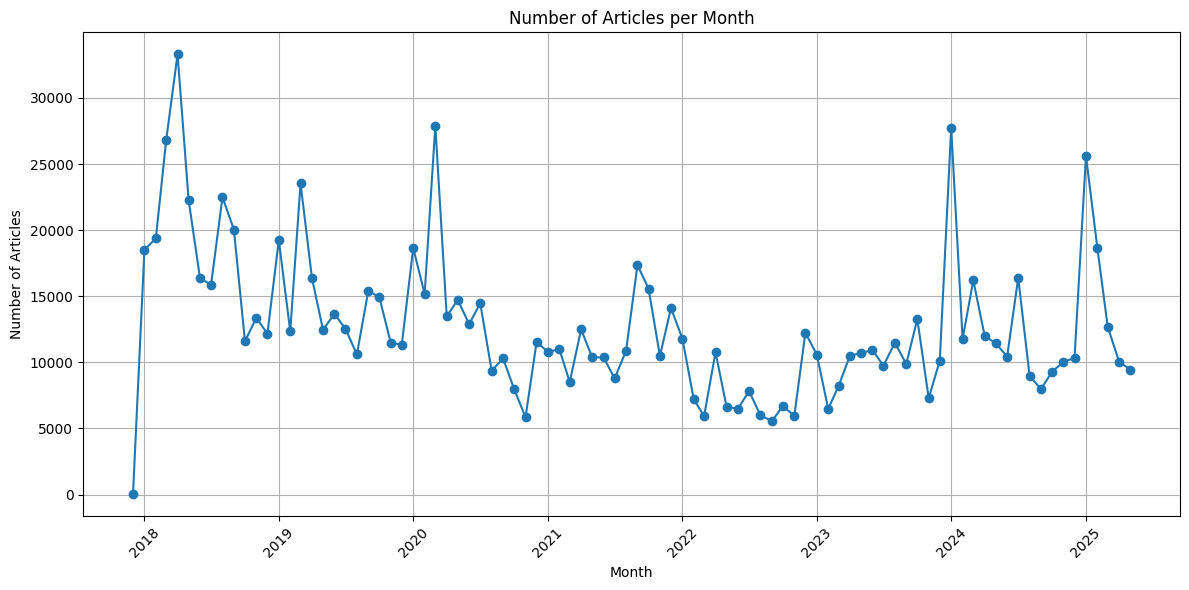

In [21]:
# count articles by month
df['month'] = df['datetime'].dt.to_period('M')
monthly_counts = df.groupby('month').size().reset_index(name='article_count')
# Convert 'month' back to datetime for plotting
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()
# Plotting the number of articles per month
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['month'], monthly_counts['article_count'], marker='o')
plt.title('Number of Articles per Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

In [40]:
df=df[['date','datetime', 'article_title', 
 'Alaska Airlines','American Airlines','Delta Air Lines','JetBlue','Southwest Airlines','United Airlines','Allegiant Air','Tone'
 ]].dropna()

In [41]:
# now merge the rank_df with the original df
df = pd.merge(df, rank_df, on='date', how='left')

In [42]:
df

,date,datetime,article_title,Alaska Airlines,American Airlines,Delta Air Lines,JetBlue,Southwest Airlines,United Airlines,Allegiant Air,Tone,event_rank_general,event_rank_Alaska Airlines,event_rank_American Airlines,event_rank_Delta Air Lines,event_rank_JetBlue,event_rank_Southwest Airlines,event_rank_United Airlines,event_rank_Allegiant Air
0,2023-02-20,2023-02-20 22:00:00,airborne 02 20 23: hobby balloon shot down per...,0,1,0,0,0,0,0,-1.228501,1430.0,1408.0,1239.0,1313.0,1120.0,1488.0,1405.0,2582.0
1,2025-01-17,2025-01-17 18:45:00,trump s inauguration will be held inside what ...,0,1,0,0,1,1,0,0.418410,2452.0,1151.0,1593.0,2266.0,2521.0,2657.0,2032.0,466.0
2,2024-05-27,2024-05-27 05:30:00,boeing safety product quality concerns surge a...,0,0,0,0,0,1,0,-3.271028,1330.0,2110.0,1613.0,1695.0,1915.0,1459.0,1012.0,2218.0
3,2025-04-10,2025-04-10 13:15:00,breaking down luka s first game back in dallas...,0,1,0,0,0,0,0,0.123305,551.0,413.0,60.0,2682.0,1737.0,420.0,1516.0,2079.0
4,2024-11-20,2024-11-20 08:15:00,will spirit airlines bankruptcy ruin louisiana...,0,0,0,0,0,1,0,-1.453488,2254.0,2096.0,1577.0,1295.0,2604.0,497.0,887.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150562,2022-12-16,2022-12-16 09:00:00,they flew to nashville bluebell their dog was ...,0,0,0,0,0,1,0,-1.756440,1064.0,1081.0,1162.0,1719.0,584.0,1118.0,1048.0,1043.0
1150563,2019-07-18,2019-07-18 21:45:00,nation southwest cancellations will rise due t...,0,1,0,0,1,0,0,-1.813472,219.0,72.0,391.0,62.0,222.0,112.0,322.0,2116.0
1150564,2019-07-18,2019-07-18 21:45:00,nation southwest cancellations will rise due t...,0,1,0,0,1,0,0,-1.813472,219.0,72.0,391.0,62.0,222.0,112.0,322.0,2116.0
1150565,2018-01-20,2018-01-20 01:30:00,delta apos cracking down apos,0,1,1,0,0,0,0,-0.879397,314.0,66.0,587.0,388.0,862.0,2086.0,537.0,508.0


In [43]:
df_filter=df[
    (df['Southwest Airlines']==1) &
    (df['datetime'] >=datetime.datetime(2018, 4, 16)) &
    (df['datetime']<=datetime.datetime(2018, 4, 18))
    ]

df_filter.sort_values(by='datetime', inplace=True)
df_filter

,date,datetime,article_title,Alaska Airlines,American Airlines,Delta Air Lines,JetBlue,Southwest Airlines,United Airlines,Allegiant Air,Tone,event_rank_general,event_rank_Alaska Airlines,event_rank_American Airlines,event_rank_Delta Air Lines,event_rank_JetBlue,event_rank_Southwest Airlines,event_rank_United Airlines,event_rank_Allegiant Air
589556,2018-04-16,2018-04-16 00:30:00,travel advice flights things you didnt know ab...,0,1,0,0,1,1,0,-0.530223,62.0,1588.0,939.0,777.0,19.0,2006.0,757.0,1.0
846244,2018-04-16,2018-04-16 02:15:00,travel advice things you didnt know about your...,0,1,0,0,1,1,0,-0.710227,62.0,1588.0,939.0,777.0,19.0,2006.0,757.0,1.0
846005,2018-04-16,2018-04-16 02:15:00,things you didnt know about your flight number...,0,1,0,0,1,1,0,-0.710227,62.0,1588.0,939.0,777.0,19.0,2006.0,757.0,1.0
632058,2018-04-16,2018-04-16 03:15:00,things you didnt know about your flight number...,0,1,0,0,1,1,0,-0.710227,62.0,1588.0,939.0,777.0,19.0,2006.0,757.0,1.0
1025904,2018-04-16,2018-04-16 03:30:00,travel advice things you didnt know about your...,0,1,0,0,1,1,0,-0.710227,62.0,1588.0,939.0,777.0,19.0,2006.0,757.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602795,2018-04-18,2018-04-18 00:00:00,opinion article_6c56a2a0 42a0 11e8 b606 87e270...,0,0,0,0,1,0,0,-2.223634,23.0,1288.0,132.0,455.0,2229.0,3.0,2404.0,2693.0
602794,2018-04-18,2018-04-18 00:00:00,opinion article_462cfc90 42b5 11e8 8823 8394a8...,0,0,0,0,1,0,0,-1.470588,23.0,1288.0,132.0,455.0,2229.0,3.0,2404.0,2693.0
602793,2018-04-18,2018-04-18 00:00:00,world_article_66fc6d24 11f4 5817 8c3b eaecc419...,0,0,0,0,1,0,0,-0.475436,23.0,1288.0,132.0,455.0,2229.0,3.0,2404.0,2693.0
602791,2018-04-18,2018-04-18 00:00:00,article_b3849dca 42b5 11e8 980c bfda4,0,0,0,0,1,0,0,-2.872063,23.0,1288.0,132.0,455.0,2229.0,3.0,2404.0,2693.0


In [44]:
topics = ['Alaska Airlines','American Airlines','Delta Air Lines','JetBlue','Southwest Airlines','United Airlines','Allegiant Air']

for topic in topics:
    df[f'event_rank_{topic}'] = df[f'event_rank_{topic}'] * df[topic]
    df[f'event_rank_{topic}'] = np.where(df[f'event_rank_{topic}'] == 0, np.nan, df[f'event_rank_{topic}'])

In [45]:
titles = df['article_title'].value_counts()
titles.to_csv(r'../../Data/Processed/gdelt_article_titles.csv', index=True)
titles

article_title
                                                                                            7852
article cfm c_id=2&objectid=                                                                 413
article cfm c_id=3&objectid=                                                                 390
how 9 11 changed air travel: more security less privacy                                      370
sheriff naked man threatened to bomb florida airport                                         349
                                                                                            ... 
fl orlando ap online ground max jets could contribute to higher summer fares                   1
delta profit intact after controversial loyalty changes                                        1
allegiant offering seasonal services to myrtle beach from syracuse hancock int l airport       1
mavericks luka doncic reveals gift for daughter s first birthday                               1
american airline

In [46]:
# Reshape longer by topic
df_long = df.melt(id_vars=['date', 'article_title'], 
                  value_vars=[f'event_rank_{topic}' for topic in topics],
                  var_name='topic', value_name='event_rank')
df_long['article_title'].replace('', np.nan, inplace=True)
df_long.dropna(inplace=True)

df_long=df_long[df_long['event_rank']<=5]

# Group by date, article title, topic, and event rank, counting the number of articles
df_long = df_long.groupby(['topic', 'event_rank', 'date', 'article_title']).size().reset_index(name='article_count')

In [47]:
df_long.sort_values(by=['topic', 'event_rank', 'date', 'article_count'], ascending=[True,True,True,False], inplace=True)

# For each ['date', 'topic', 'event_rank'], keep the first 3 rows
df_long = df_long.groupby(['topic', 'event_rank', 'date']).head(3).reset_index(drop=True)
df_long['top_article_'] = df_long.groupby(['topic', 'event_rank', 'date']).cumcount() + 1

df_long

,topic,event_rank,date,article_title,article_count,top_article_
0,event_rank_Alaska Airlines,1.0,2018-08-11,plane stolen by suicidal employee crashes near...,256,1
1,event_rank_Alaska Airlines,1.0,2018-08-11,suicidal mechanic steals plane from seattle ai...,188,2
2,event_rank_Alaska Airlines,1.0,2018-08-11,probe under way after suicidal employee steals...,139,3
3,event_rank_Alaska Airlines,2.0,2024-01-06,faa orders grounding of certain boeing 737 max...,113,1
4,event_rank_Alaska Airlines,2.0,2024-01-06,alaska airlines grounds 737 max 9 fleet after ...,93,2
...,...,...,...,...,...,...
100,event_rank_United Airlines,4.0,2018-08-24,tourists rescued as hurricane lane hits hawaii...,65,2
101,event_rank_United Airlines,4.0,2018-08-24,content 5 tourists rescued from flooded home a...,49,3
102,event_rank_United Airlines,5.0,2020-01-31,fever alarms paranoia as masked passengers fly...,116,1
103,event_rank_United Airlines,5.0,2020-01-31,us bars foreigners coming from china for now o...,77,2


In [48]:
# Reshape article titles to wide format using top_article_
df_wide = df_long.pivot_table(index=['topic', 'event_rank', 'date'], 
                               columns='top_article_', 
                               values='article_title', 
                               aggfunc='first').reset_index()

df_wide['topic'].replace('event_rank_','', inplace=True)
df_wide.rename(columns={
    'topic': 'airline',
    1: 'article_title_1', 
    2: 'article_title_2', 
    3: 'article_title_3'
    }, inplace=True)

df_wide

top_article_,airline,event_rank,date,article_title_1,article_title_2,article_title_3
0,event_rank_Alaska Airlines,1.0,2018-08-11,plane stolen by suicidal employee crashes near...,suicidal mechanic steals plane from seattle ai...,probe under way after suicidal employee steals...
1,event_rank_Alaska Airlines,2.0,2024-01-06,faa orders grounding of certain boeing 737 max...,alaska airlines grounds 737 max 9 fleet after ...,us officials order grounding of boeing 737 9 m...
2,event_rank_Alaska Airlines,3.0,2024-01-08,boeing jetliner that suffered inflight blowout...,before a door plug flew off a boeing plane an ...,united airlines finds loose bolts other proble...
3,event_rank_Alaska Airlines,4.0,2024-07-08,boeing accepts a plea deal to avoid a criminal...,boeing agrees to plead guilty and pay a nearly...,boeing accepts plea deal to avoid criminal tri...
4,event_rank_Alaska Airlines,5.0,2023-10-23,an off duty pilot is accused of trying to shut...,an off duty pilot attempted to shut off the en...,off duty pilot charged with 83 counts of attem...
5,event_rank_Allegiant Air,1.0,2018-04-16,allegiant air under fire after 60 minutes safe...,nation allegiant air under fire after 60 minut...,flights todayinthesky allegiant air defends sa...
6,event_rank_Allegiant Air,2.0,2024-07-19,your flight was canceled by the technology out...,crowdstrike outage: what to know if you re tra...,global tech outage: what to know if you re tra...
7,event_rank_Allegiant Air,3.0,2024-10-07,hurricane milton reaches category 4 strength d...,fast growing hurricane milton is officially a ...,hurricane milton intensifies explosively into ...
8,event_rank_Allegiant Air,4.0,2023-04-28,new report blames airlines for most flight can...,gov t report blames airlines for flight cancel...,allegiant launches pilot pathway program | aer...
9,event_rank_Allegiant Air,5.0,2022-11-05,airline delays and cancellations continue to p...,best and worst airlines and airports ranked fo...,johnson back as owner driver in bucket list races


In [49]:
df_wide.to_csv('../../output/gdelt_top_events.csv', index=False)